In [1]:
import sys
sys.path.insert(1,'../functions/')
import torch
from torch import nn
import numpy as np
import data_sim
import matplotlib.pyplot as plt
import xarray as xr
import copy
import pandas as pd
from torch.utils.data import Dataset, DataLoader
#from slab_spike_model_constructor import *
from full_slab_spike_model_constructor import *
from training_func import *
import pyreadr
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Read in the data

In [2]:
ABCD = pd.read_csv('../dataset/abcd.csv')
list_ROI = pyreadr.read_r('../dataset/ABCD_ROI.list.RData')

/var/folders/cy/7rpv9wdx3nb25gzbj78xgqwm0000gn/T/ipykernel_31877/286607271.py:1: DtypeWarning: Columns (23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  ABCD = pd.read_csv('../dataset/abcd.csv')


In [35]:
from torch.utils.data import Dataset, DataLoader
import os
class inference_on_data(object):
    def __init__(self, data, outcome_vars, 
                  modality_vars, modality_vars_dict, 
                  lr = 0.05, batch_size = None, tobit = True, 
                  device = 'cpu', random_seed = 1):
        self.data = data
        self.outcome_vars = outcome_vars
        self.modality_vars = modality_vars
        self.modality_vars_dict = modality_vars_dict
        
        self.lr = lr
        self.batch_size = batch_size
        self.tobit = True
        self.device = device
        self.random_seed = 1
    
    def run(self, outcome_name, modality_name):
        image_var = list(np.squeeze(self.modality_vars_dict[modality_name].values,1))
        cov = image_var.copy()
        cov.extend([outcome_name,'eventname',
            "mri_info_manufacturers.model.name", 'race.6level', 'age', 'female', 'subjectid', 'demo_rel_family_id.bl'])
        #import pdb; pdb.set_trace()
        # getting the relevent columns
        ABCD_sub = self.data.loc[:,np.isin(self.data.columns,cov)]
        # getting the subjects without na
        ABCD_sub = ABCD_sub.loc[~ABCD_sub.isnull().any(axis = 1),:]
        # sample one subject in the families
        ABCD_sub = ABCD_sub.groupby('demo_rel_family_id.bl', 
                                    group_keys=False).apply(lambda x: x.sample(1, random_state = self.random_seed)).reset_index(drop=True)
        # sample one subject in the visit
        ABCD_sub = ABCD_sub.groupby(['subjectid','eventname'], 
                                    group_keys=False).apply(lambda x: x.sample(1, random_state = self.random_seed)).reset_index(drop=True)
        # drop the subjectid and family id
        ABCD_sub.drop(columns = ['subjectid', 'demo_rel_family_id.bl','eventname'], inplace=True)
        # Onehotencode the categorical variables
        cate_cov = ['race.6level', 'female',"mri_info_manufacturers.model.name"]
        OHE = OneHotEncoder(drop = 'first',sparse_output = False).fit(ABCD_sub[cate_cov])
        encoded_cols = list(OHE.get_feature_names_out(cate_cov))
        ABCD_sub[encoded_cols] = OHE.transform(ABCD_sub[cate_cov])
        # Confounders variable
        confounders = encoded_cols+['age']
        # Setting up the numpy array
        X = ABCD_sub[confounders+image_var].to_numpy()
        # Standardization
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
        z = ABCD_sub[outcome_name].to_numpy() 
        # smallest value at 0
        z = z- min(z)
        p_confound = len(confounders)
        p = X.shape[1] - p_confound
        n = X.shape[0]
        # Model setup
        if self.batch_size == None:
            batch_size = X.shape[0]
        else:
            batch_size = batch_size
        exact_lh = True
        tobit = self.tobit
        X = torch.tensor(X)
        z = torch.tensor(z)
        sim_data = Sim_Dataset(X, z, device = self.device)
        sim_data_loader = DataLoader(sim_data, batch_size = batch_size)
        true_beta = np.zeros((p,))
        model = linear_slab_spike(p = p, n_total = n, p_confound = p_confound,init_pi_local_max = 1.0, 
                                  init_pi_local_min = 0.0,init_pi_global = 0.5, init_beta_var =1, init_noise_var = 1,
                                  gumbel_softmax_temp = 1, gumbel_softmax_hard = False, 
                                  a1= 0.1, a2=0.1, init_a3= 1.1, init_a4 = 1.1,
                                  b1 = 1.1, b2 = 1.1, init_b3 = 10.0, init_b4 = 0.1, n_E = 1
                                  , prior_sparsity = True, prior_sparsity_beta = False,
                                  exact_lh = exact_lh,tobit = self.tobit, device = self.device
                                 ).double().to(self.device)
        optimizer = torch.optim.Adam(model.parameters(),lr = 0.05)
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.8)
        t = 100 #number of moving averages
        patience = 100# patience
        best_model, error, point_est, result_dict = train_and_infer(model = model, optimizer = optimizer,
                                                                    sim_data_loader = sim_data_loader, 
                                                                    lr_scheduler = lr_scheduler, t = t, 
                                                                    patience = patience,X = X, plot = True, 
                                                                    true_beta = true_beta, lr_schedule_step = 1000,
                                                                    verbose = False)
        pi_local_est = torch.sigmoid(best_model.logit_pi_local)
        beta_est = best_model.beta_mu
        top_k_pi, indices = torch.topk(pi_local_est, 10)
        top_k_beta_est = beta_est[indices].cpu().detach().numpy()
        top_k_pi = top_k_pi.cpu().detach().numpy()
        indices = indices.numpy()
        top_k_name = np.array(image_var)[indices]
        dict_top_k = {'outcome': np.repeat(outcome_name, len(top_k_name)),
                      'modality':np.repeat(modality_name, len(top_k_name)),
                      'var_name': top_k_name, 'pi':top_k_pi}
        dict_beta_pi = {'beta':beta_est.cpu().detach().numpy(),'pi': pi_local_est.cpu().detach().numpy()}
        result_dict['outcome']=outcome_name
        result_dict['modality'] = modality_name
        result_dict['mse'] = np.mean(np.square(error))
        # Transform to dataframe
        result_df = pd.DataFrame(result_dict)
        top_k_df = pd.DataFrame(dict_top_k)
        return result_df, top_k_df, dict_beta_pi, point_est
    
    def full_run(self,save_path = ''):
        result_df_l = []
        top_k_df_l = []
        for o in self.outcome_vars:
            for m in self.modality_vars:
                result_df, top_k_df, dict_beta_pi, point_est = self.run(o, m)
                result_df_l.append(result_df)
                top_k_df_l.append(top_k_df)
        total_result = pd.concat(result_df_l)
        top_k_result = pd.concat(top_k_df_l)
        total_result.to_csv(os.path.join(save_path, 'ABCD_h_sparsity.csv'))
        top_k_result.to_csv(os.path.join(save_path, 'ABCD_top_k_variable.csv'))
        return total_result, top_k_result
                

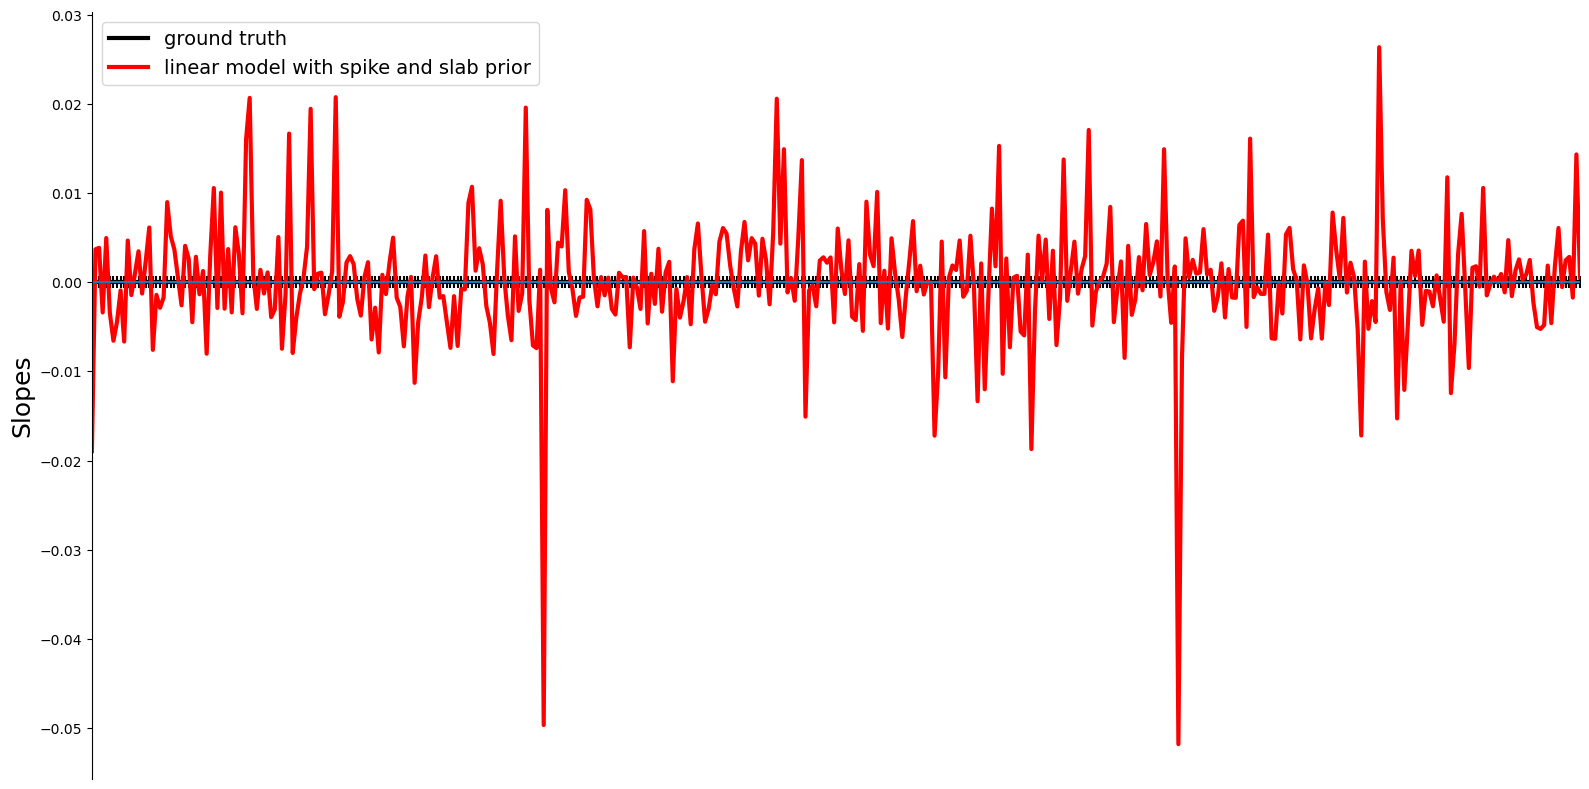

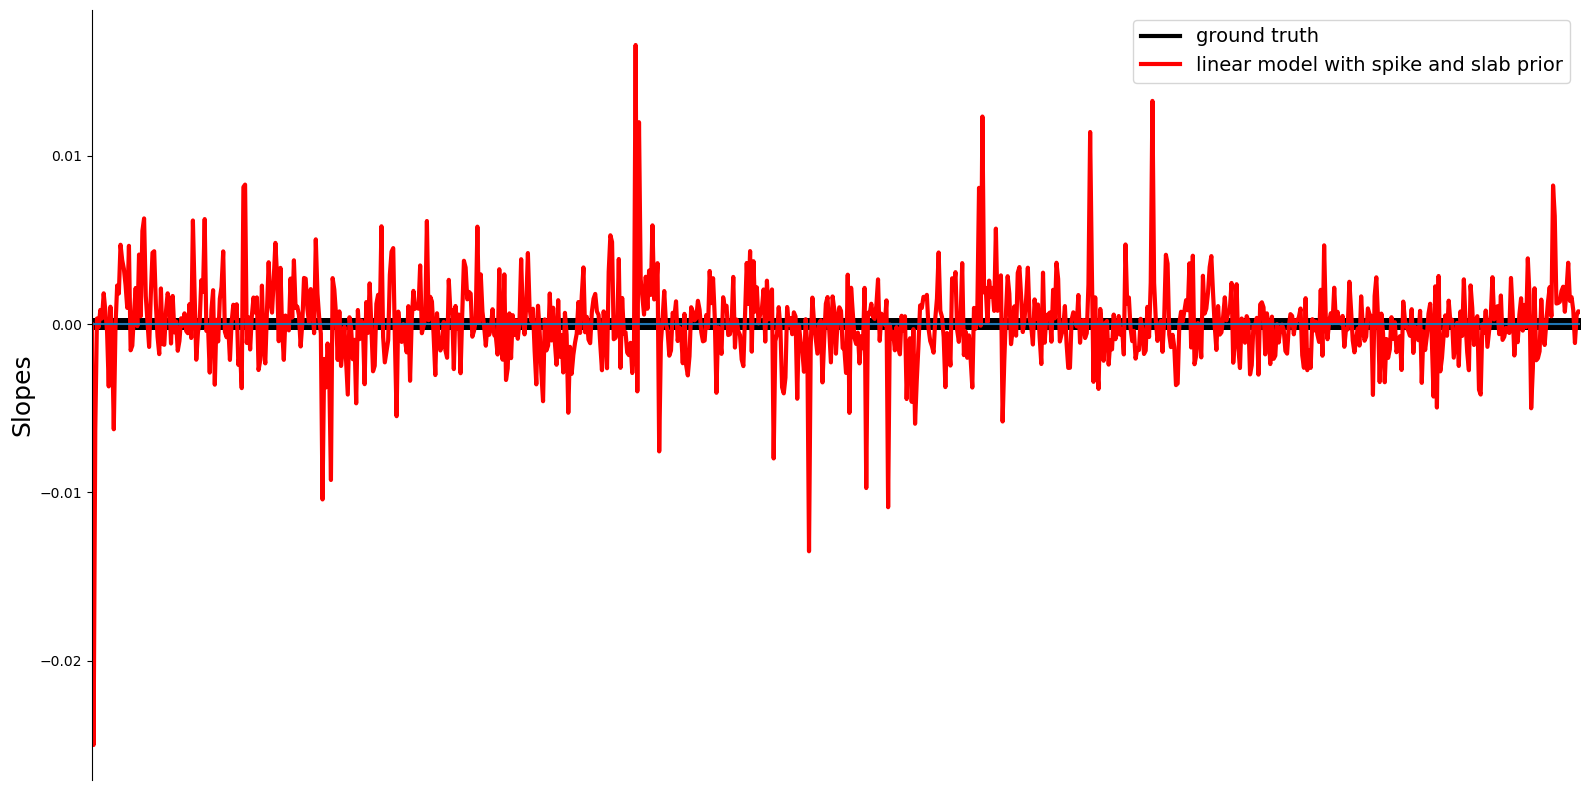

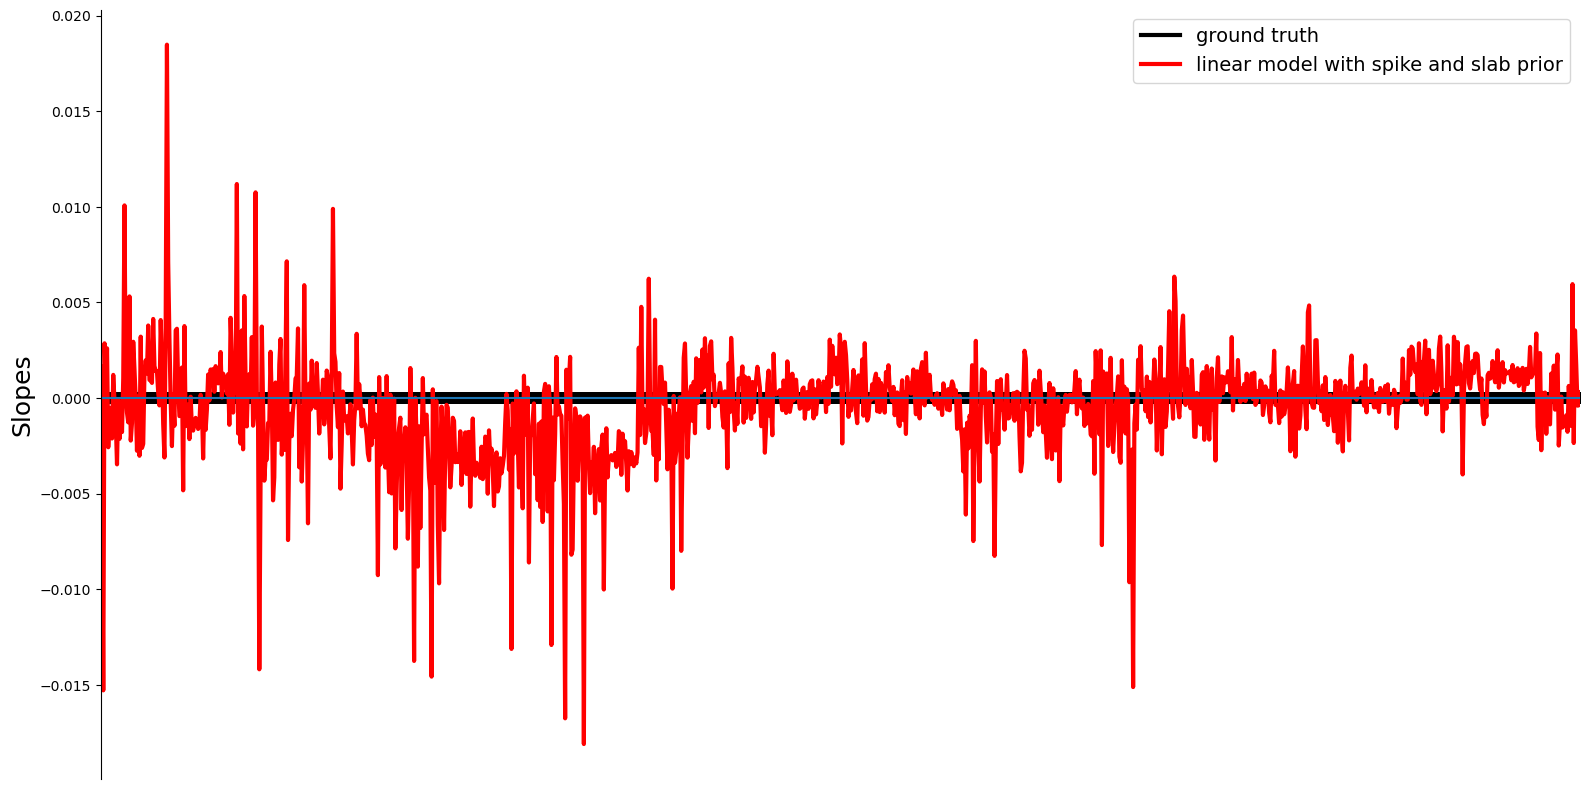

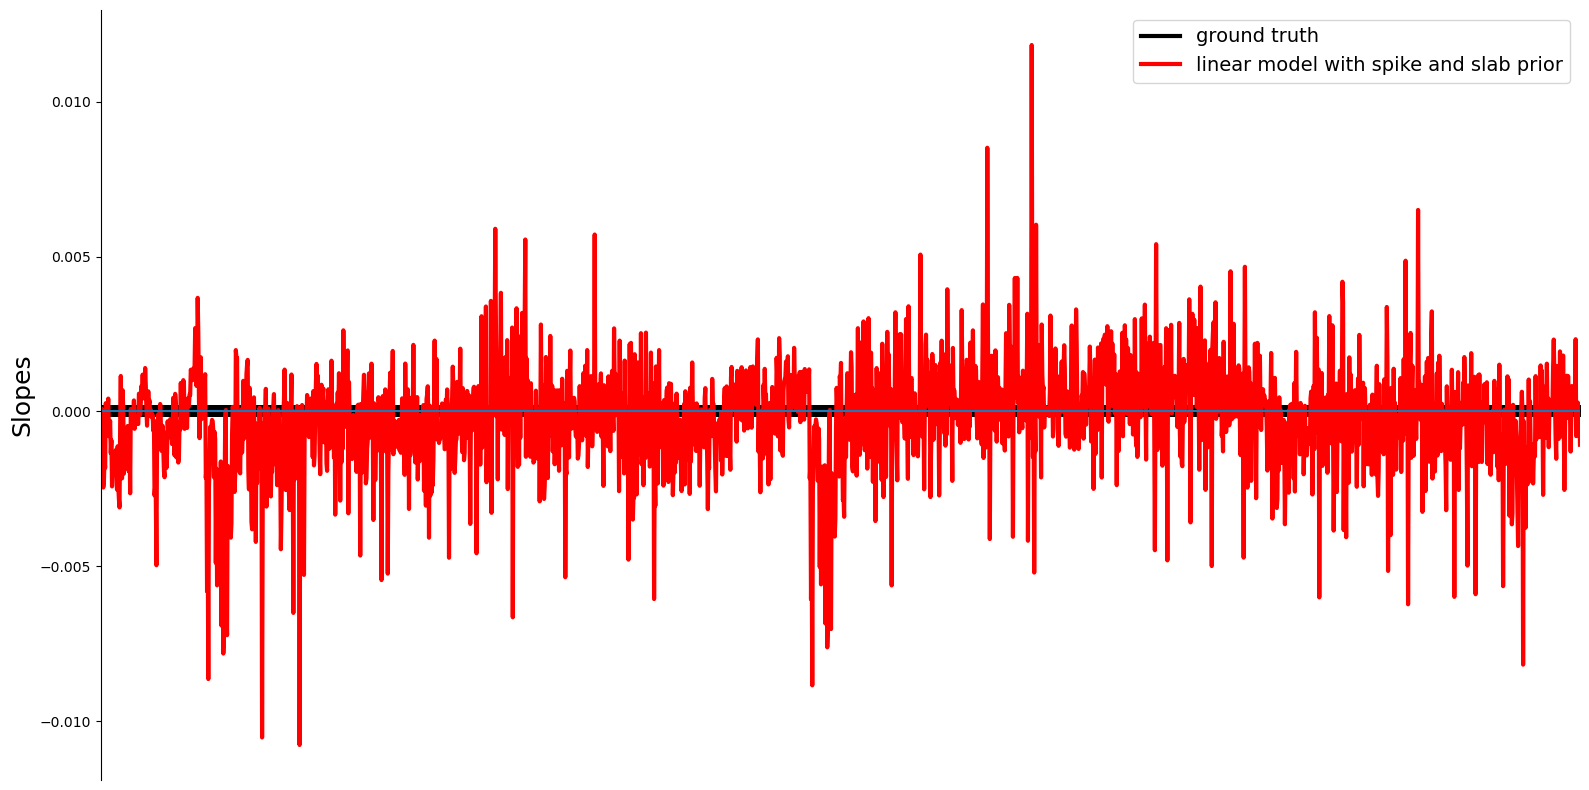

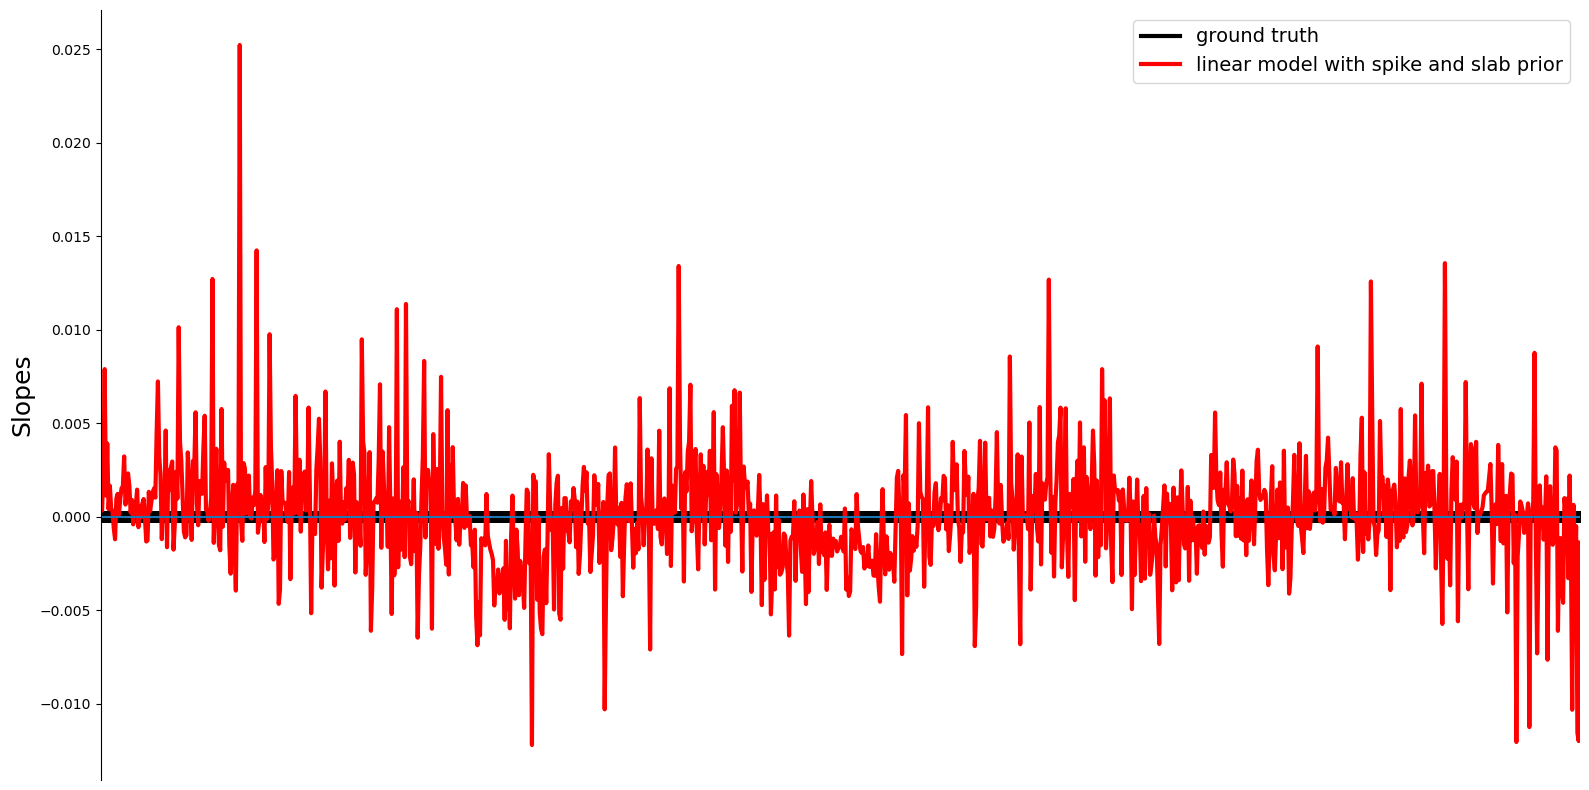

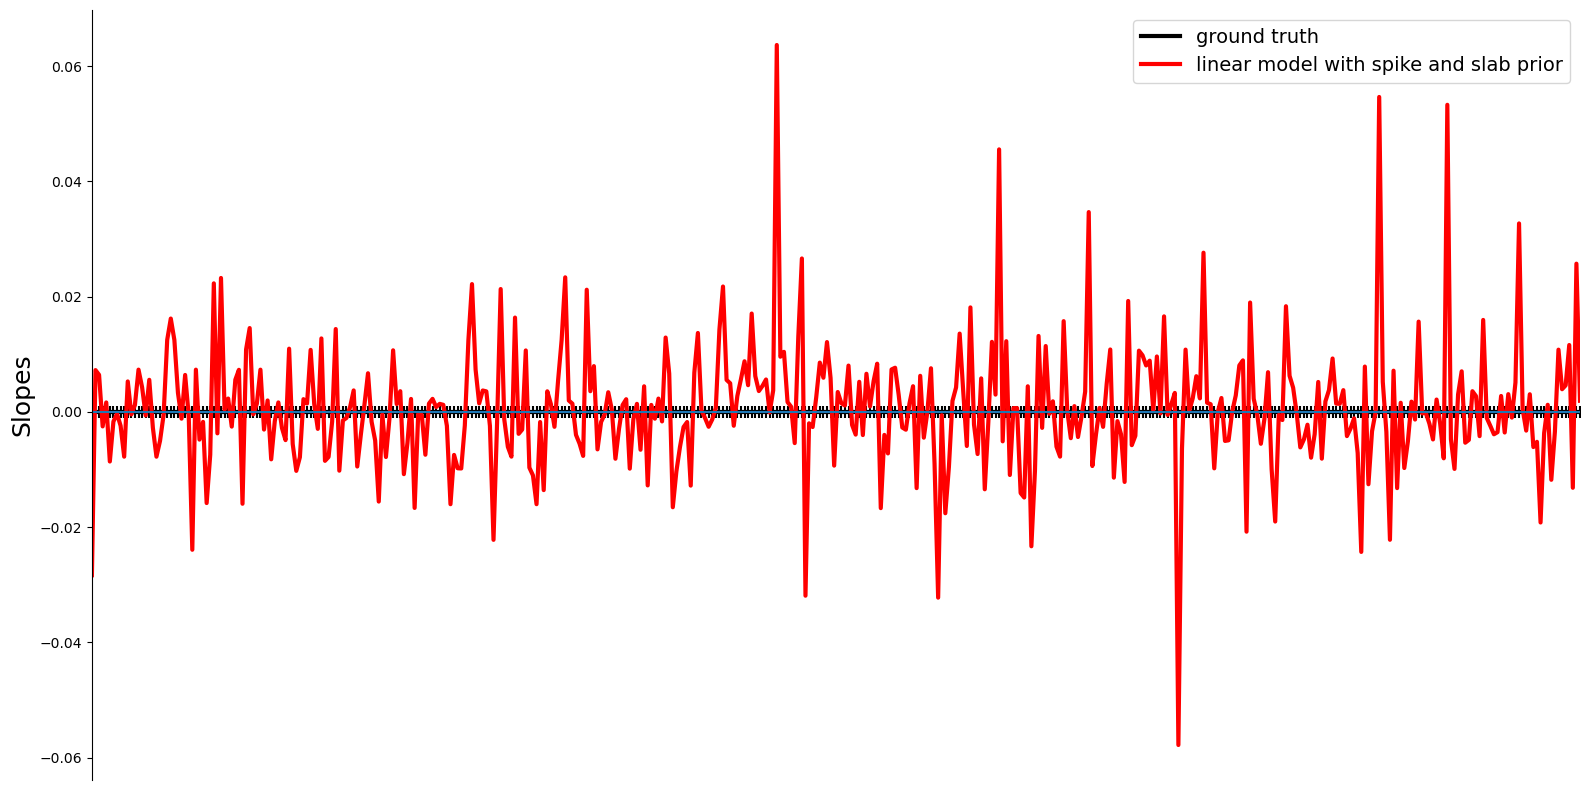

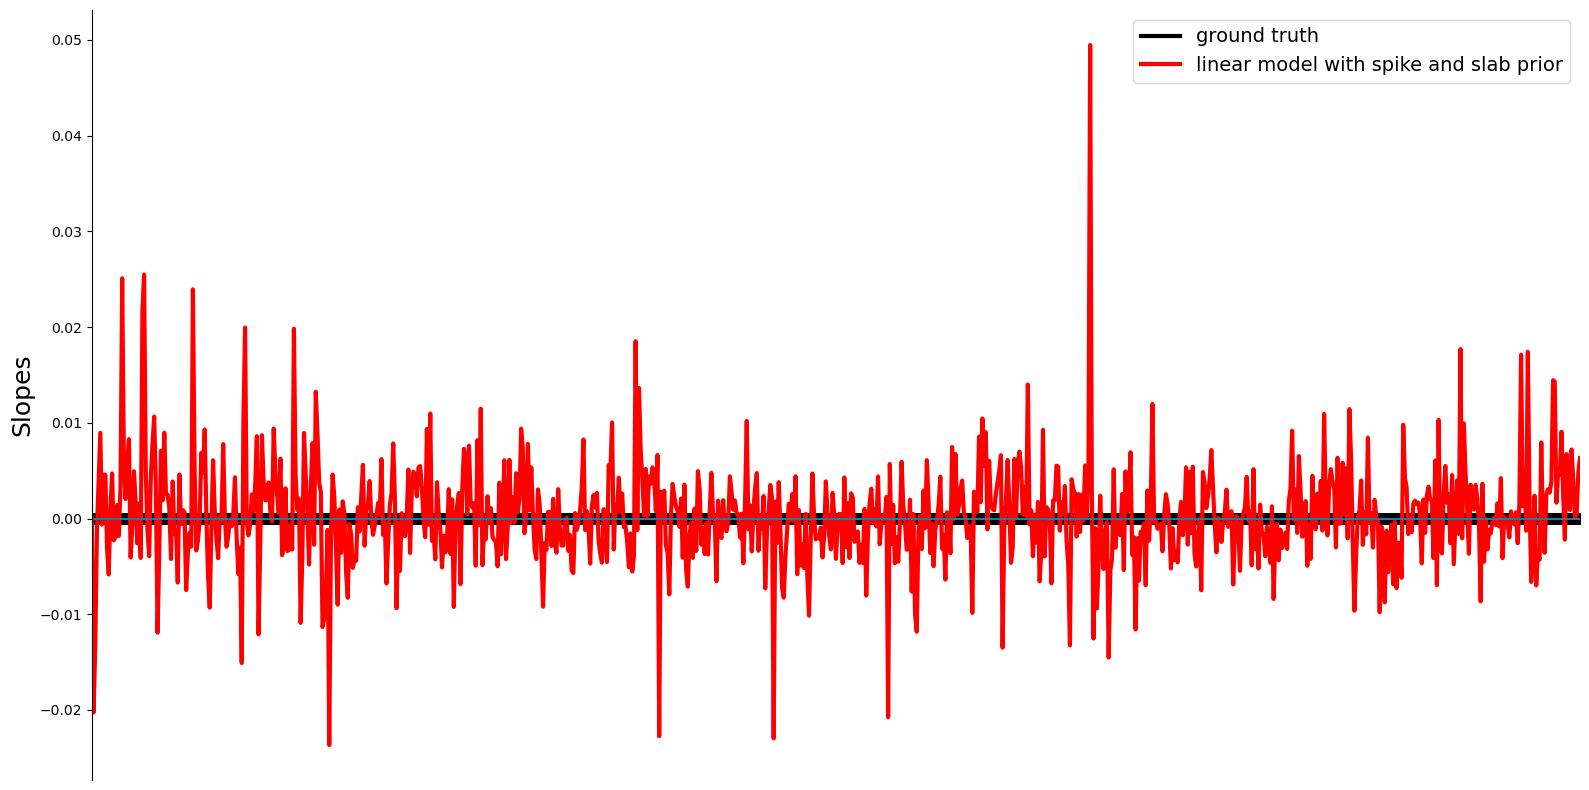

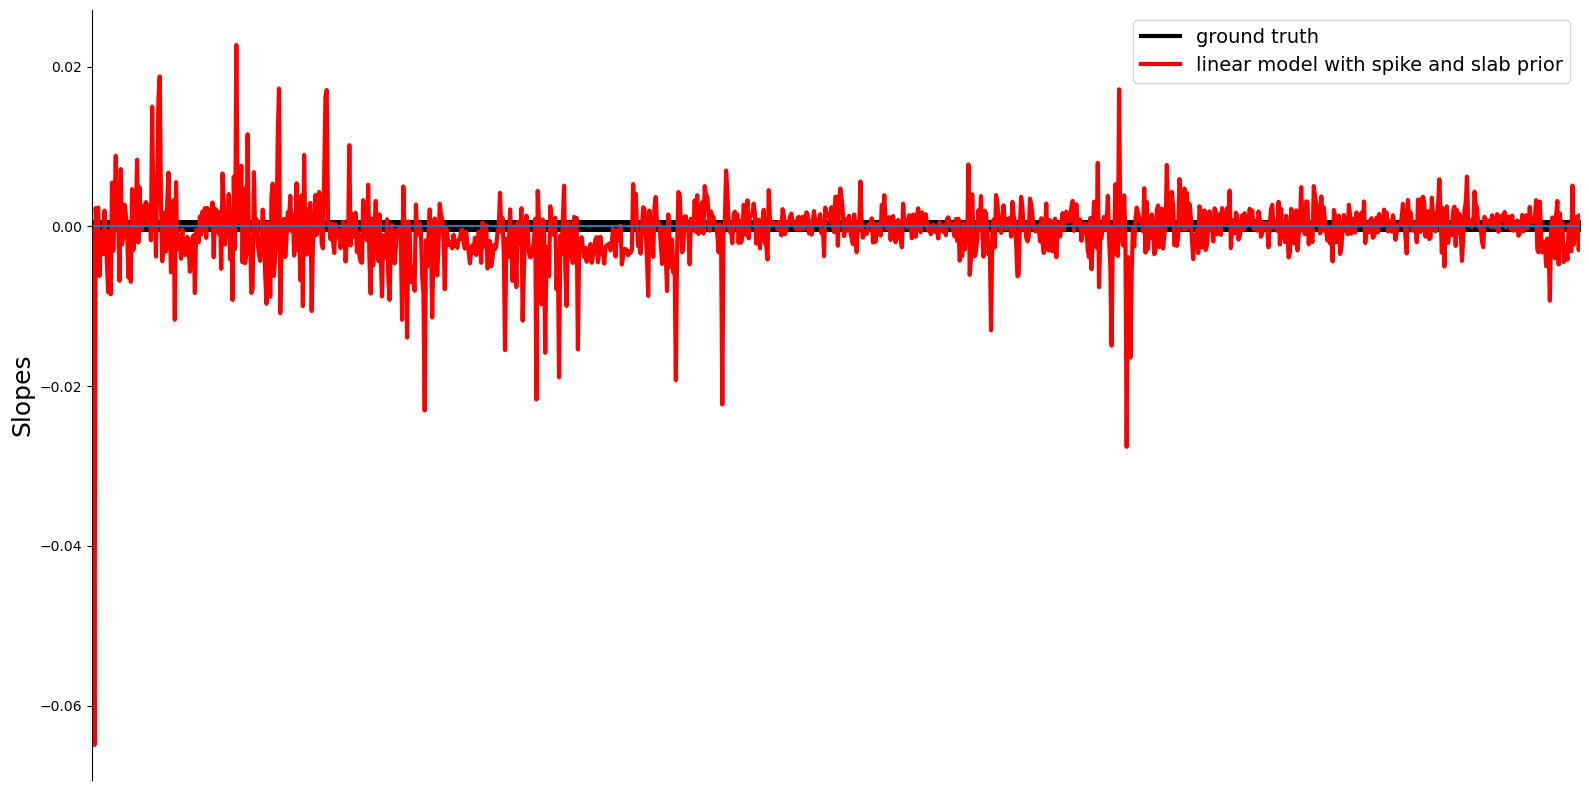

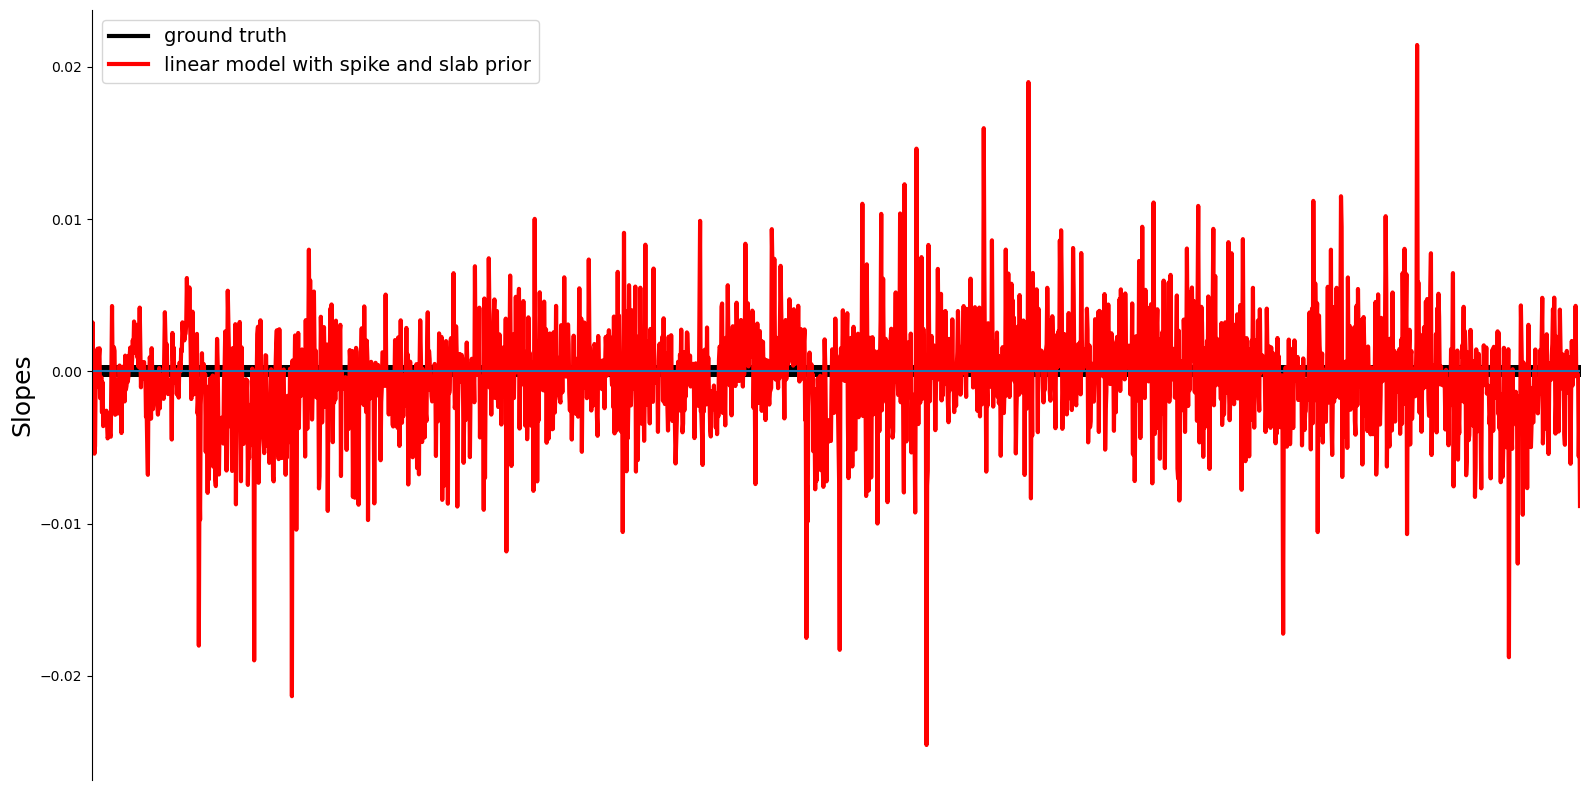

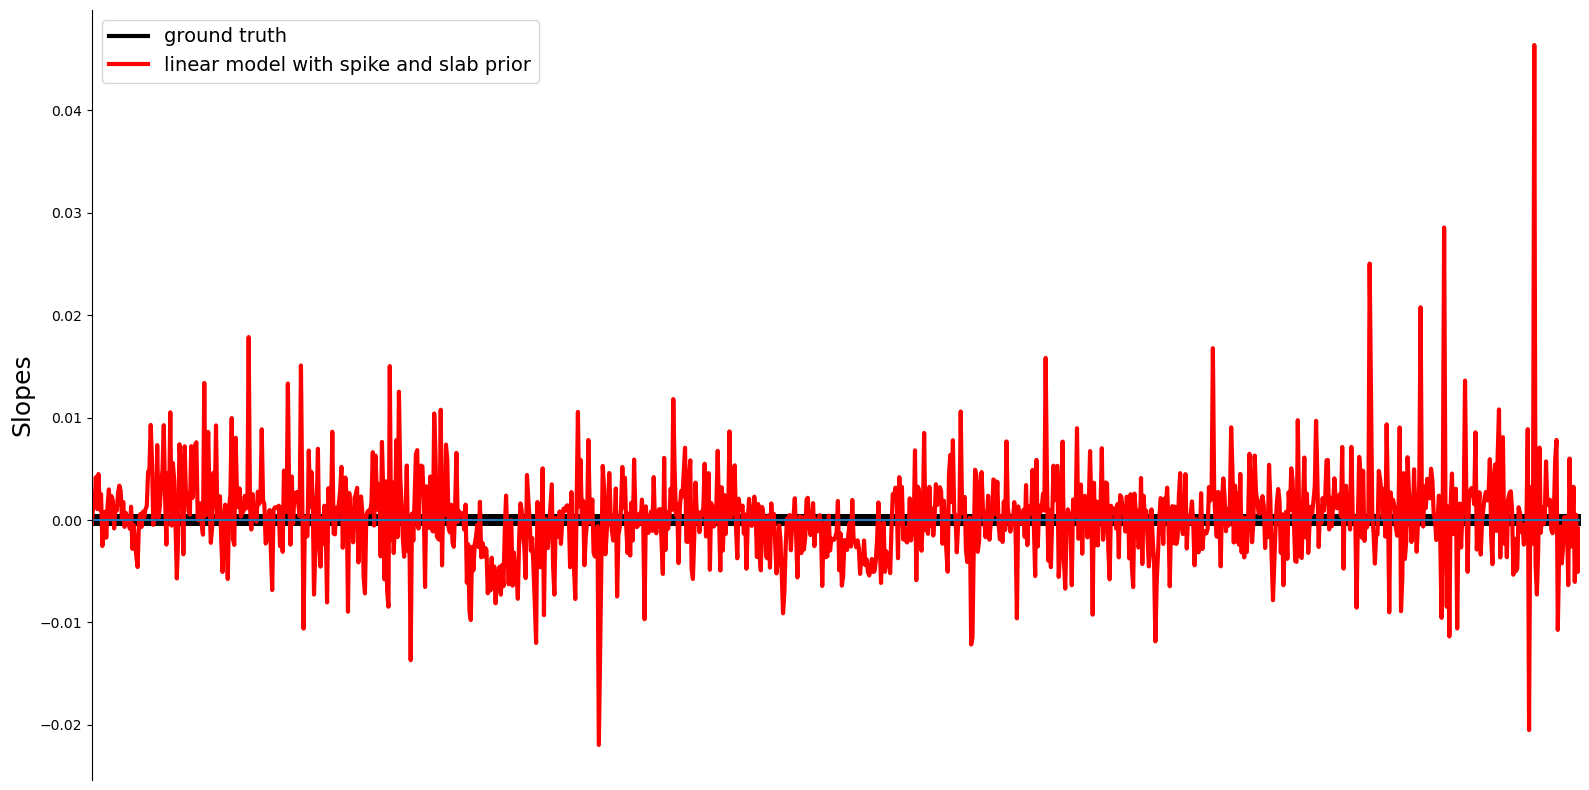

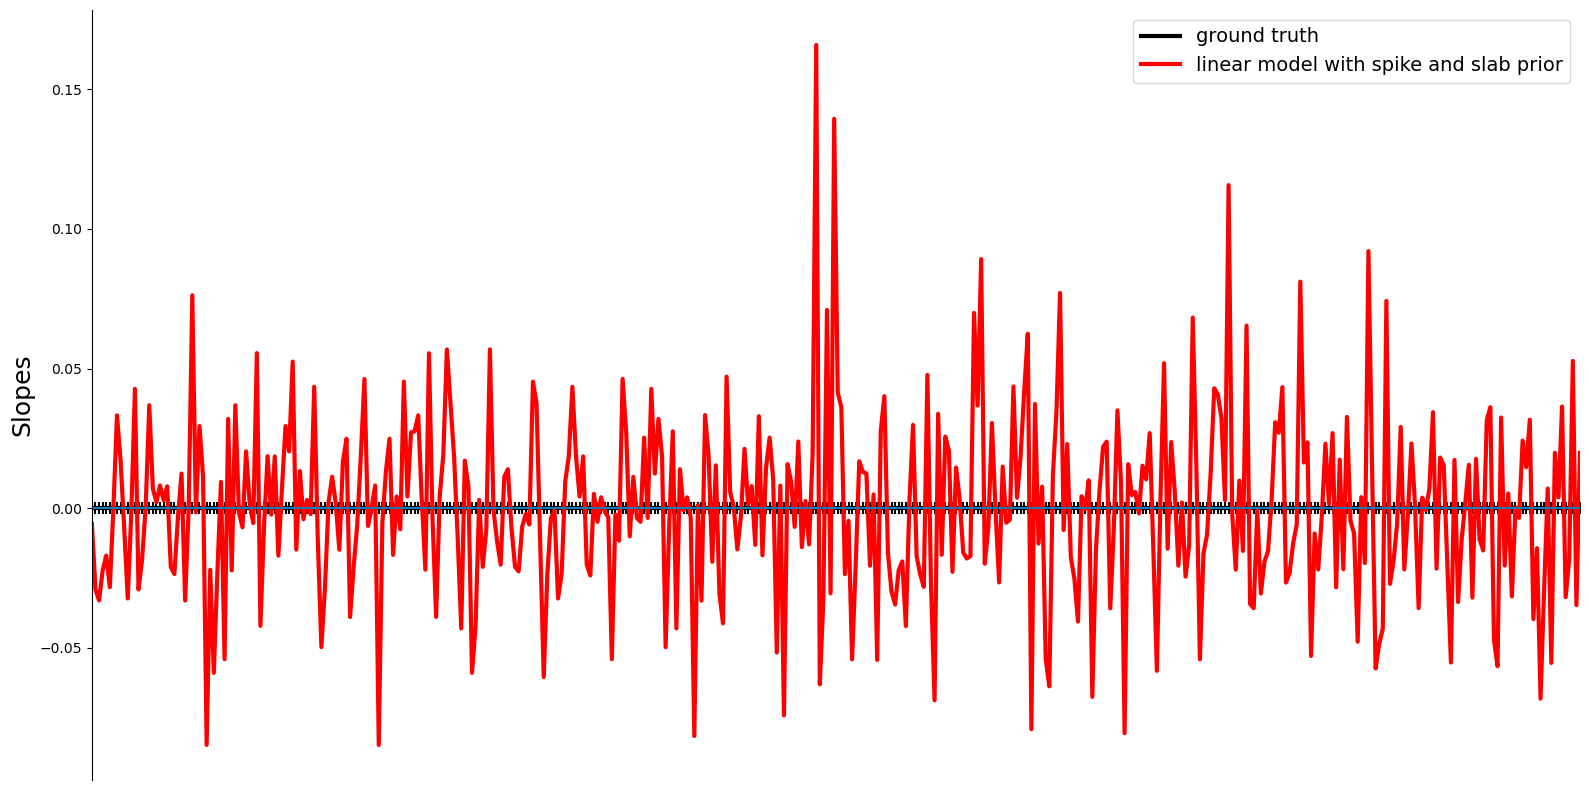

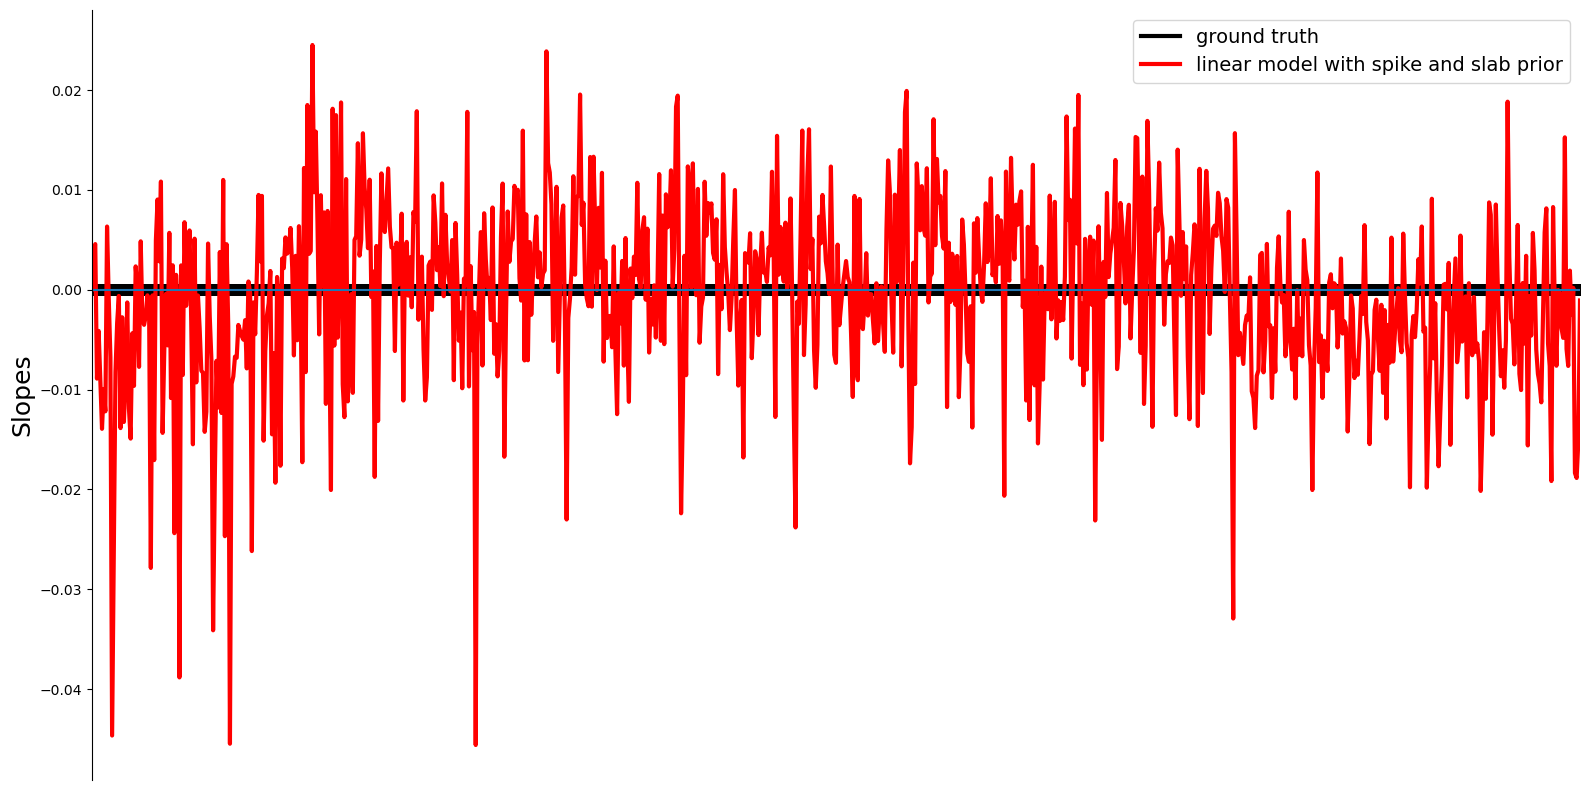

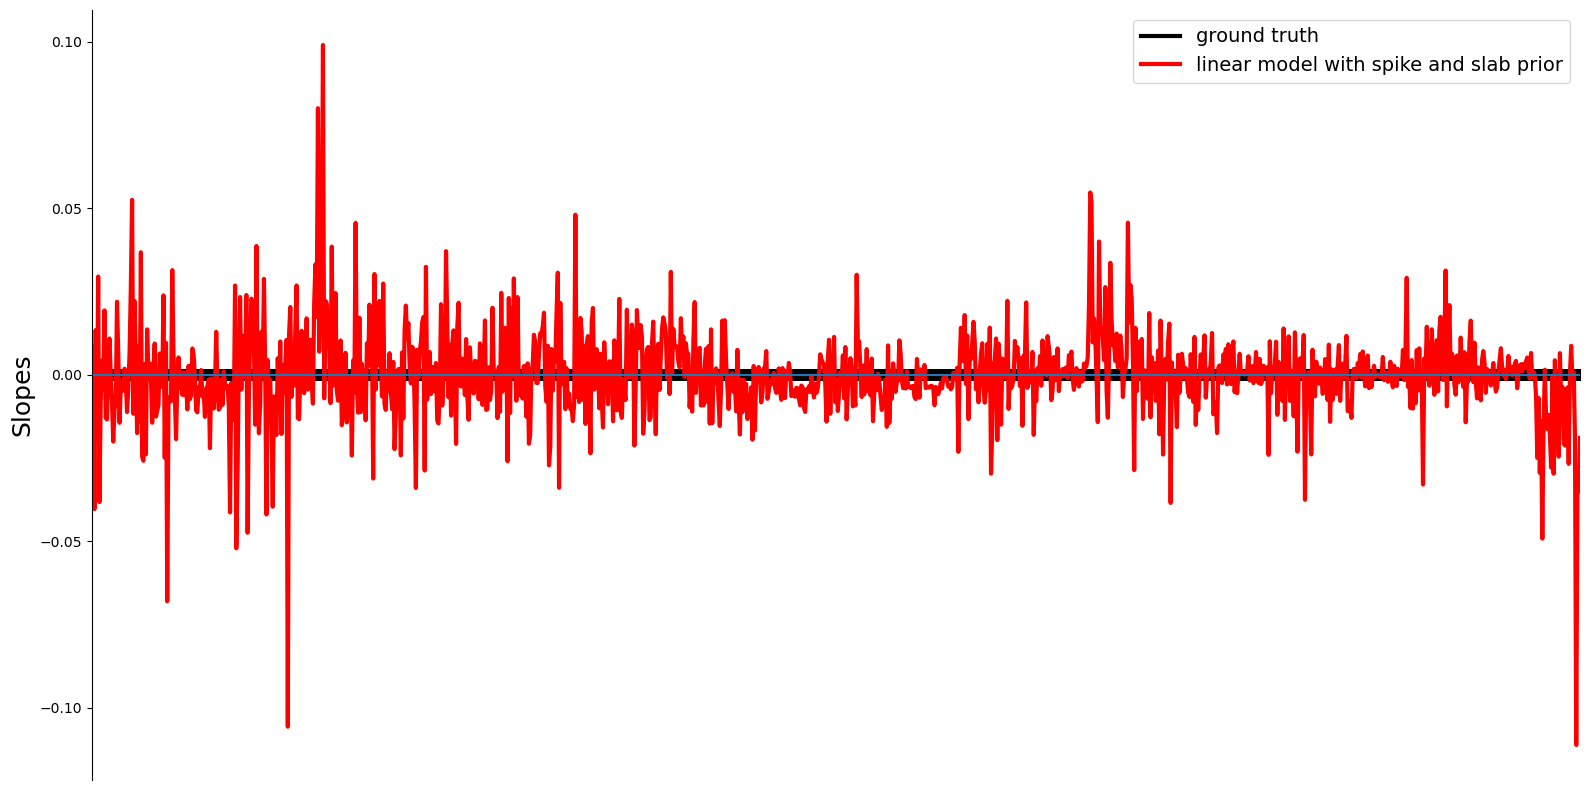

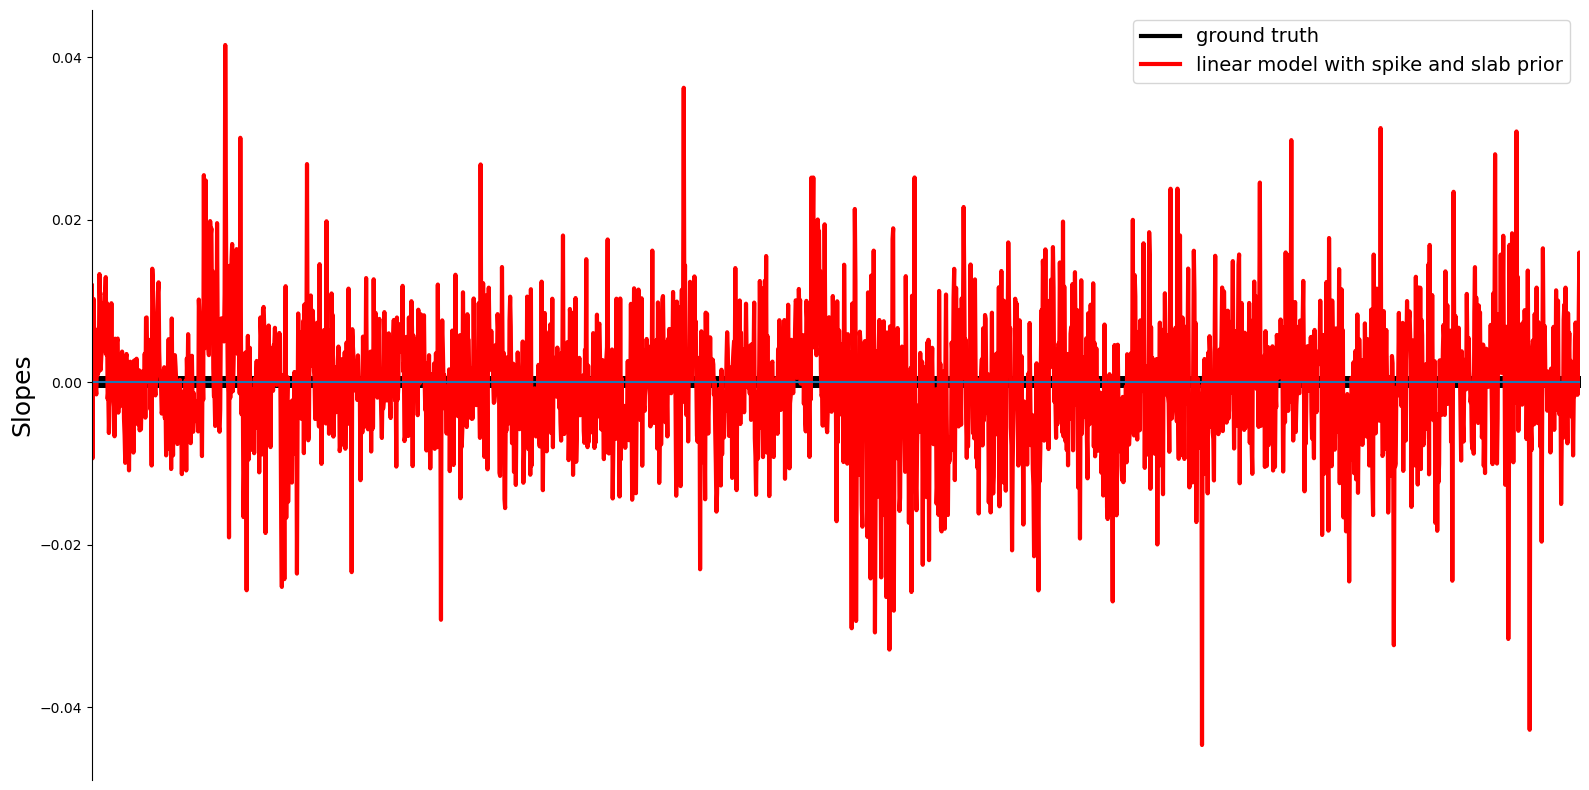

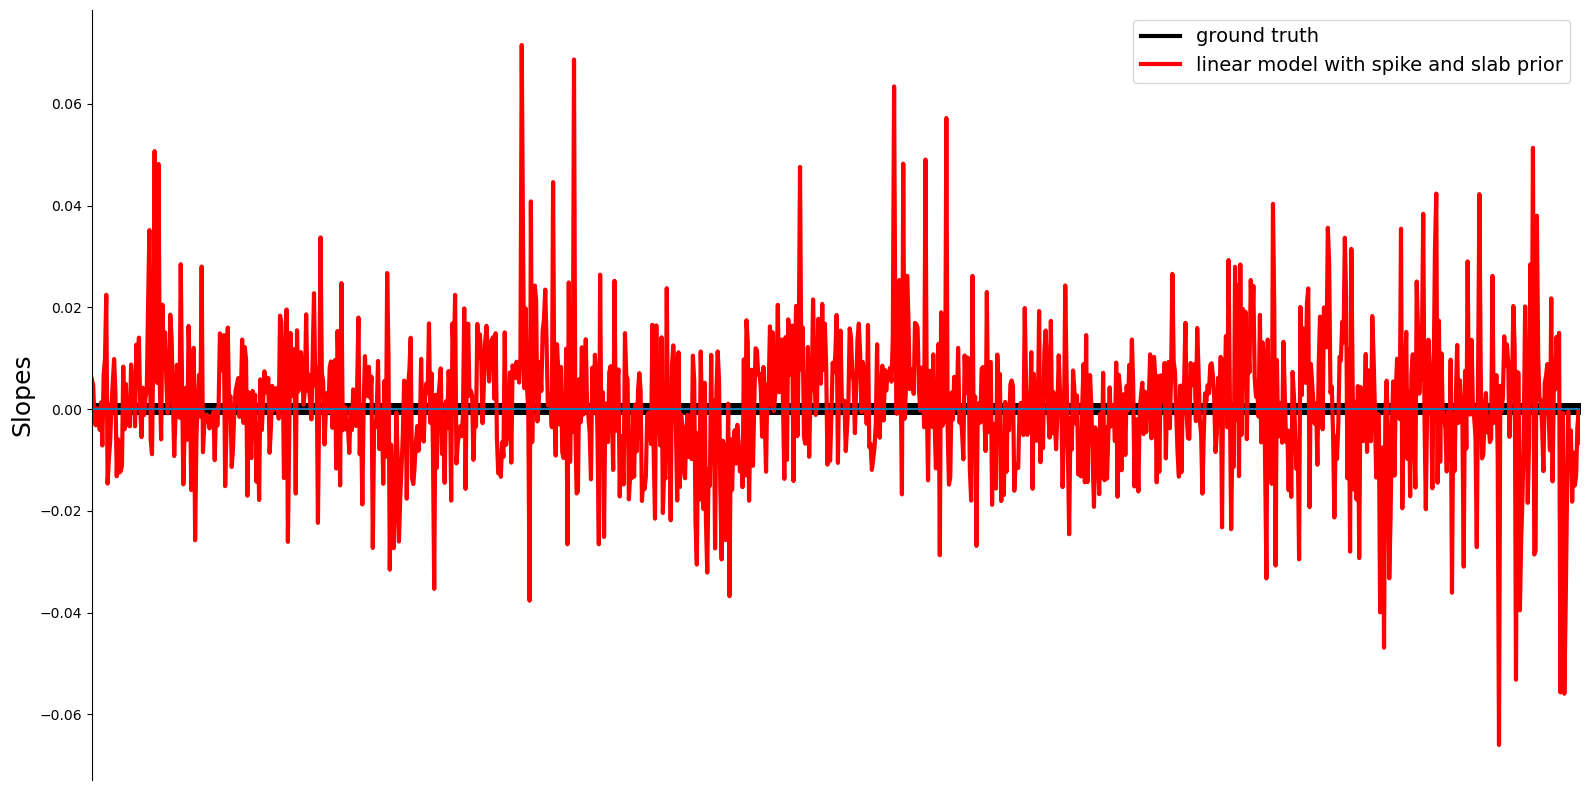

In [36]:
outcome_vars = ['cbcl_scr_syn_internal_t', 'cbcl_scr_syn_anxdep_t', 'abcl_scr_sub_use_alcohol_t']
modality_vars = ['rsmri_list', 'tfmri_list', 'smri_list', 'dti_list', 'rsi_list']
temp = inference_on_data(data = ABCD,  
                         outcome_vars = outcome_vars, 
                         modality_vars = modality_vars,
                         modality_vars_dict = list_ROI)
total_result, top_k_result = temp.full_run()

In [28]:
result_df

,mean_h_est,h_est_upper,h_est_lower,mean_var_genetic,noise_var,global_pi,global_pi_upper,global_pi_lower,outcome,modality,mse
0,0.027732,0.031664,0.024964,3.673031,128.792123,0.098966,0.18172,0.040208,cbcl_scr_syn_internal_t,rsmri_list,112.227737


In [23]:
pd.DataFrame(dict_top_k)

,outcome,modality,var_name,pi
0,cbcl_scr_syn_internal_t,rsmri_list,rsfmri_cor_network.gordon_retrosplenialtempora...,0.334028
1,cbcl_scr_syn_internal_t,rsmri_list,rsfmri_cor_network.gordon_smmouth_network.gord...,0.332564
2,cbcl_scr_syn_internal_t,rsmri_list,rsfmri_cor_network.gordon_salience_subcort.ase...,0.207033
3,cbcl_scr_syn_internal_t,rsmri_list,rsfmri_cor_network.gordon_default_network.gord...,0.179485
4,cbcl_scr_syn_internal_t,rsmri_list,rsfmri_cor_network.gordon_dorsalattn_network.g...,0.179408
5,cbcl_scr_syn_internal_t,rsmri_list,rsfmri_cor_network.gordon_cingulooperc_subcort...,0.178926
6,cbcl_scr_syn_internal_t,rsmri_list,rsfmri_cor_network.gordon_smmouth_network.gord...,0.178909
7,cbcl_scr_syn_internal_t,rsmri_list,rsfmri_cor_network.gordon_frontoparietal_netwo...,0.178548
8,cbcl_scr_syn_internal_t,rsmri_list,rsfmri_cor_network.gordon_auditory_network.gor...,0.172160
9,cbcl_scr_syn_internal_t,rsmri_list,rsfmri_cor_network.gordon_dorsalattn_subcort.a...,0.170604


In [ ]:
ABCD_sub = ABCD
#'cbcl_scr_syn_internal_t', 'cbcl_scr_syn_anxdep_t', 'abcl_scr_sub_use_alcohol_t',
outcome_var = 'cbcl_scr_syn_internal_t'
# 'rsmri_list', 'tfmri_list', 'smri_list', 'dti_list', 'rsi_list'
modality_var ='tfmri_list'
cov = list(np.squeeze(list_ROI[modality_var].values,1))
cov.extend([outcome_var,'eventname',
            "mri_info_manufacturers.model.name", 'race.6level', 'age', 'female', 'subjectid', 'demo_rel_family_id.bl'])
# getting the relevent columns
ABCD_sub = ABCD_sub.loc[:,np.isin(ABCD_sub.columns,cov)]
# getting the subjects without na
ABCD_sub = ABCD_sub.loc[~ABCD_sub.isnull().any(axis = 1),:]
# sample one subject in the families
ABCD_sub = ABCD_sub.groupby('demo_rel_family_id.bl', group_keys=False).apply(lambda x: x.sample(1)).reset_index(drop=True)
# sample one subject in the visit
ABCD_sub = ABCD_sub.groupby(['subjectid','eventname'], group_keys=False).apply(lambda x: x.sample(1)).reset_index(drop=True)
# drop the subjectid and family id
ABCD_sub.drop(columns = ['subjectid', 'demo_rel_family_id.bl','eventname'], inplace=True)
# Onehotencode the categorical variables
cate_cov = ['race.6level', 'female',"mri_info_manufacturers.model.name"]
OHE = OneHotEncoder(drop = 'first',sparse_output = False).fit(ABCD_sub[cate_cov])
encoded_cols = list(OHE.get_feature_names_out(cate_cov))
ABCD_sub[encoded_cols] = OHE.transform(ABCD_sub[cate_cov])


In [ ]:
confounders = encoded_cols+['age']
variables = list(np.squeeze(list_ROI[modality_var].values,1))
X = ABCD_sub[confounders+variables].to_numpy()
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
z = ABCD_sub[outcome_var].to_numpy() 
z = z- min(z)
p_confound = len(confounders)
p = X.shape[1] - p_confound
n = X.shape[0]

In [ ]:
p

In [ ]:
print(X.shape)

In [ ]:
plt.hist(z)

In [ ]:
# Model parameters
batch_size = X.shape[0]
exact_lh = True
tobit = True
device = 'cpu'
X = torch.tensor(X)
z = torch.tensor(z)
sim_data = Sim_Dataset(X, z, device = device)
sim_data_loader = DataLoader(sim_data, batch_size = batch_size)
true_beta = np.zeros((p,))
model = linear_slab_spike(p = p, n_total = n, p_confound = p_confound,init_pi_local_max = 1.0, init_pi_local_min = 0.0,init_pi_global = 0.5, init_beta_var =1, init_noise_var = 1,
                         gumbel_softmax_temp = 1, gumbel_softmax_hard = False, 
                          a1= 0.1, a2=0.1, init_a3= 1.1, init_a4 = 1.1,
                          b1 = 1.1, b2 = 1.1, init_b3 = 10.0, init_b4 = 0.1, n_E = 1
                          , prior_sparsity = True, prior_sparsity_beta = False,exact_lh = exact_lh,tobit = tobit, device = device
                         ).double().to(device)
optimizer = torch.optim.Adam(
    [{'params': model.beta_mu},
     {'params': model.beta_log_var},
     {'params': model.logit_pi_local},
     {'params': model.log_a3},
     {'params': model.log_a4},
     {'params': model.b3},
     {'params': model.log_b4},
     {'params': model.bias},
     {'params': model.logit_pi_global},
     {'params': model.beta_log_var_prior},
     {'params': model.log_var_noise},
     {'params': model.beta_confound}
    ],
    lr = 0.05)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.8)
t = 100 #number of moving averages
patience = 100# patience
best_model, error, point_est, result_dict = train_and_infer(model = model, optimizer = optimizer, sim_data_loader = sim_data_loader, lr_scheduler = lr_scheduler, t = t, patience = patience,X = X, plot = True, true_beta = true_beta, verbose = True)

In [26]:
result_dict

{'mean_h_est': [0.029030306163171184],
 'h_est_upper': [0.03297361626304423],
 'h_est_lower': [0.02651924665665399],
 'mean_var_genetic': [3.8984627900969104],
 'noise_var': [130.41846743645823],
 'global_pi': [0.06382444330039864],
 'global_pi_upper': [0.12453205480490188],
 'global_pi_lower': [0.022000835804441583]}

In [27]:
pi_local_est = torch.sigmoid(best_model.logit_pi_local).detach().numpy()
beta_est = best_model.beta_mu.detach().numpy()*pi_local_est
print(max(pi_local_est))
print(min(pi_local_est))

0.17008009169792995
0.04663409383463236


In [29]:
print(np.array(variables)[np.where(pi_local_est>0.15)[0]])
print(beta_est[np.where(pi_local_est>0.1)[0]])

['tfmri_nback_all_beta_dof' 'tfmri_nback_all_beta_nvols'
 'tfmri_nback_all_posface.vs.neutface_beta_subcort.aseg_pallidum.rh']
[-0.02164123 -0.02157982  0.01488445  0.01425272 -0.01457725 -0.01056067
 -0.01281137  0.01150597 -0.01965815  0.01309272 -0.01355184 -0.01128776
  0.01178174  0.01297523  0.00970036  0.01086326  0.01042033]


In [18]:
torch.arange(1,6)[torch.topk(torch.arange(1,6), 3)[1]]

tensor([5, 4, 3])

In [19]:
torch.topk(torch.arange(1,6), 3)[1].numpy()

array([4, 3, 2])